#Welcome to TrainRandom Forest
####Run All the cells in order

In [1]:
!pip install rpy2==3.5.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=318074 sha256=420fbba2e712d43c0e63e286c781bd991d0f2e441d48508b2cd900b4221b0b72
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.5.5
    Uninstalling rpy2-3.5.5:
      Successfully uninstalled rpy2-3.5.5


In [2]:
%load_ext rpy2.ipython

#Importing Packages and libraries

In [4]:
%%R

install.packages('dplyr')
install.packages('stats')
install.packages('tidyr')
install.packages('scales')
install.packages('randomForest')
install.packages('ggplot2')
install.packages('yaml')
install.packages("googledrive")



set.seed(123)
library(dplyr)
library(stats)
library(tidyr)
library(scales)
library(randomForest)
library(ggplot2)
library(yaml)


(as ‘lib’ is unspecified)







	‘/tmp/Rtmpk90fei/downloaded_packages’

(as ‘lib’ is unspecified)

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpk90fei/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpk90fei/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpk90fei/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpk90fei/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpk90fei/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpk90fei/downloaded_packages’

Attaching package: ‘dplyr’



    filter, lag



    intersect, setdiff, setequal, union




Attaching package: ‘randomForest’



    combine


Attaching package: ‘ggplot2’



    margin




#Uploading Files depending on location

###If files are in local:
#####A) Either load the files to Google Colab directly using the Google Colab feature in the image shown below. And then continue with the rest of the code.
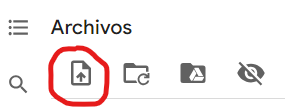
#####B) Upload to your Google Drive the files, and go to the previous step. And then continue with the following code.
#####Google Drive Accession:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Importing info

In [5]:
%%R
Data_dir <- "/content/drive/MyDrive/BEHAV3D-main/demos/tcell_demo/data" #@param {type:"string"}
Output_dir <- "/content/drive/MyDrive/BEHAV3D-main/demos/tcell_demo/example_output" #@param {type:"string"}
Metadata_dir <- "/content/drive/MyDrive/BEHAV3D-main/demos/tcell_demo/BEHAV3D_metadata.tsv" #@param {type:"string"}
reference_map <- "/content/drive/MyDrive/BEHAV3D-main/references/Behavioral_Referance_map_git" #@param {type:"string"}
model_output_path <- "/content/drive/MyDrive/BEHAV3D-main/references/TrainedRandomForest.Rdata" #@param {type:"string"}


#Parameters

In [6]:
%%R
#@title Parameters to change, if not, they are set to the default values (bars are set to defaul already, only change if you know what you are doing)
organoid_min_volume <- 1000
organoid_min_track_length <- 40
organoid_exp_duration <- 300
tcell_exp_duration <- 400 #@param {type:"slider", min:0, max:600, step:1}
tcell_min_track_length <- 60 #@param {type:"slider", min:0, max:100, step:1}
tcell_max_track_length <- 60 #@param {type:"slider", min:0, max:100, step:1}
#organoid_min_volume <- 1000 #@param {type:"slider", min:500, max:1500, step:1}
#organoid_min_track_length <- 40 #@param {type:"slider", min:0, max:100, step:1}
#organoid_exp_duration <- 300 #@param {type:"slider", min:0, max:500, step:1}
umap_minimal_distance <- 0.1 #@param {type:"slider", min:0, max:1, step:0.01}
umap_n_neighbors <- 5 #@param {type:"slider", min:0, max:50, step:1}
nr_of_clusters <- 6 #@param {type:"slider", min:0, max:50, step:1}




#Models

##Preparing the data

In [15]:
%%R

output_dir <- Output_dir
train_dataset<-readRDS(reference_map)

train_dataset$cluster2<-as.numeric(train_dataset$cluster2)
train_dataset_grouped <- train_dataset %>%
  group_by(TrackID) %>%
  nest()%>%ungroup
train_dataset_1<- train_dataset_grouped%>%
  sample_frac(0.95)
train_dataset_grouped<-as.data.frame(train_dataset_grouped)%>%
  unnest(cols = c(data))
train_dataset_1<-as.data.frame(train_dataset_1)%>%
  unnest(cols = c(data))

train_dataset_2 <-train_dataset_grouped%>%filter(!TrackID%in% train_dataset_1$TrackID)

rsq <- function(x, y) summary(lm(y~x))$r.squared



train_dataset1 <- train_dataset_1%>% group_by(TrackID)%>%
  summarise(mean_speed= mean(q.speed),median_speed= median(q.speed),speed_sd= sd(q.speed),q3_speed= quantile(q.speed,0.90),
            mean_displacement = mean(q.disp),median_displacement = median(q.disp),q3_disp= quantile(q.disp,0.90),
            displacement_sd=sd(q.disp),
            mean_red_lym = mean(q.red),red_lym_sd=sd(q.red),q3_red= quantile(q.red,0.90),
            contact=mean(s.contact),mean_contact2=mean(contact2),contact2=max(contact2), cluster=mean(cluster2))

validation_dataset <- train_dataset_2%>% group_by(TrackID)%>%
  summarise(mean_speed= mean(q.speed),median_speed= median(q.speed),speed_sd= sd(q.speed),q3_speed= quantile(q.speed,0.90),
            mean_displacement = mean(q.disp),median_displacement = median(q.disp),q3_disp= quantile(q.disp,0.90),
            displacement_sd=sd(q.disp),
            mean_red_lym = mean(q.red),red_lym_sd=sd(q.red),q3_red= quantile(q.red,0.90),
            contact=mean(s.contact),mean_contact2=mean(contact2),contact2=max(contact2), cluster=mean(cluster2))


train_dataset1<-as.data.frame(train_dataset1)  ### training dataset
##set names of columns to the same:

y <-as.factor(train_dataset1[,"cluster"]) ##strack ID
x <- as.matrix(train_dataset1[,-which(names(train_dataset1) == "TrackID" | names(train_dataset1) == "cluster")]) ##data for training

model <- randomForest(y=y,x=x,ntree=100, importance=TRUE)
predictors_importance<-importance(model)
predictors_importance
model$confusion[, 'class.error']

###error of the test dataset
test_error2 <- randomForest(y=y,x=x,ntree=100, importance=TRUE,
                            xtest=validation_dataset[,2:15], ytest=as.factor(validation_dataset$cluster))





#Plots

Saving 6.67 x 6.67 in image


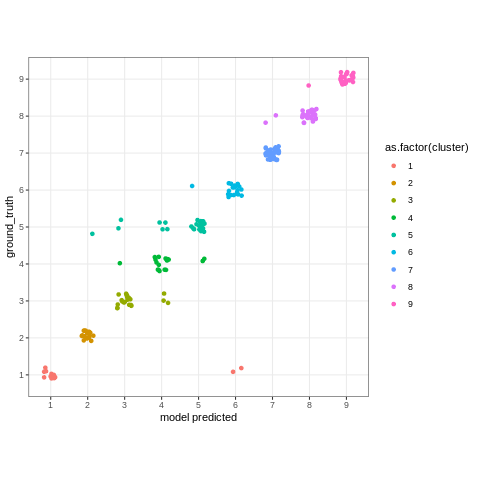

In [16]:
%%R


###Test for error per cluster using the validation dataset
## predict the cluster types in the validation dataset using the trained classifier
model_predict_train<-predict(model,validation_dataset[,-which(names(train_dataset1) == "TrackID" | names(train_dataset1) == "cluster")],type="response")
## Merge predicted and ground truth values
ground_truth<-validation_dataset[!duplicated(validation_dataset$TrackID),]
ground_truth_classified<-cbind(ground_truth,model_predict_train)
## Plot the ground truth vs predicted values
p2 <-ggplot(ground_truth_classified, aes(x=as.factor(model_predict_train),y=as.factor(cluster), color = as.factor(cluster))) +
  geom_jitter(width = 0.2, height = 0.2)+
  theme_bw() + theme(aspect.ratio = 1)+
  xlab("model predicted") +ylab("ground_truth")

#NOW I NEED TO SAVE THIS GRAPH

library(googledrive)
# Set the file names
png_filename <- "RF_GTvsPred.png"

# Save the PDF and RDS files locally
png_file <- file.path(getwd(), png_filename)

ggsave(png_file, device = "png")  # Save the PDF in the local directory


# Set the destination file path
destination_file <- file.path(Output_dir, "RF_GTvsPred.png")
# Copy the file to the destination path
file.copy(png_filename, destination_file)


print(p2)


Saving 6.67 x 6.67 in image


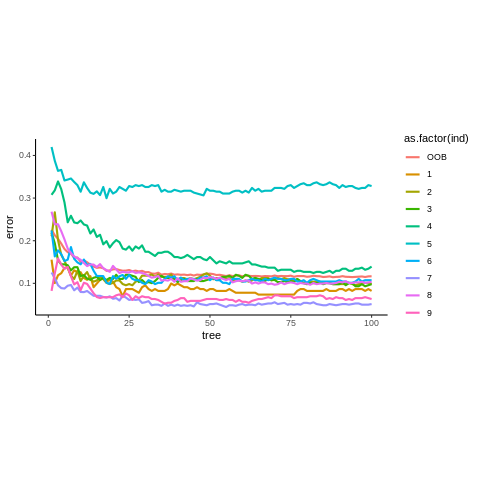

In [17]:
%%R

####Plot tree error evolution per cluster
model_df<-model[["err.rate"]]
model_df<-as.data.frame(model_df)
model_df$tree<-rownames(model_df)
model_df$tree<-as.numeric(model_df$tree)
model_df <- data.frame(tree= model_df$tree,stack(model_df,select=-tree))
model_df$ind = as.factor(model_df$ind)
p1 <-ggplot(model_df , aes(x=tree,y=values, group = ind, color = as.factor(ind))) +
  geom_line(size=1)+
  theme_classic() + theme(aspect.ratio = 0.5)+
  xlab("tree") +ylab("error")


#NOW I NEED TO SAVE THIS GRAPH

library(googledrive)
# Set the file names
png_filename <- "RF_TreeErrorEvolution.png"

# Save the PDF and RDS files locally
png_file <- file.path(getwd(), png_filename)

ggsave(png_file, device = "png")  # Save the PDF in the local directory


# Set the destination file path
destination_file <- file.path(Output_dir, "RF_TreeErrorEvolution.png")
# Copy the file to the destination path
file.copy(png_filename, destination_file)

print(p1)


save(model, file = model_output_path)


#If you want to **download the generated files until now as a zip to your local** computer, do the following:
###1) Run this code
###2) Right click on the generated file named "my_folder.zip" and click on download. Like in the image:
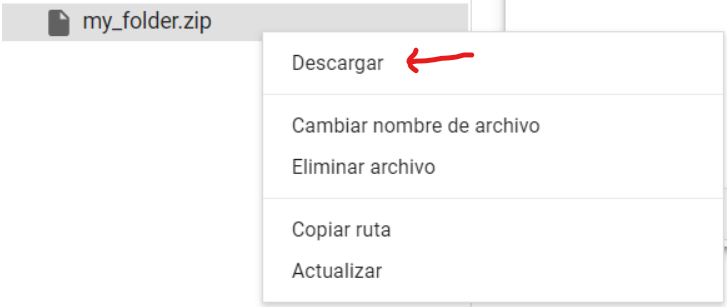

In [12]:
%%R

#Generating the folder
folder_name <- "my_folder"
dir.create(folder_name)

# Get a list of all files in the current directory
file_list <- list.files()

# Exclude files named "drive" or "sample_data"
files_to_move <- file_list[!(file_list %in% c("drive", "sample_data"))]

# Move files to the new folder
for (file in files_to_move) {
  file_path <- file
  new_path <- paste0(folder_name, "/", file)
  file.rename(file_path, new_path)
}

zip_file_path <- paste0(folder_name, ".zip")
zip(zip_file_path, files = list.files(folder_name, recursive = TRUE, full.names = TRUE))


